# inititalizing : disk access and imports  

In [ ]:
# dVFS_ExSysR_AIO_gen_   

In [1]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive/')
import os
%cd /content/drive/My\ Drive/Collab_temp/

Mounted at /content/drive/
/content/drive/My Drive/Collab_temp


In [3]:
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from random import random
import time

# defining MATRIX calcs

In [4]:
def BuildMatrixSET(CUTs, MATRIX_available):
  if MATRIX_available == 0:
    print('building MATRIX')
    print('DFT fingerprint range [0, 3700]')
    #print('trimming requested: [', xs_cut_MIN, ',', xs_cut_MAX, ']')
    xs_cut_MIN = 0
    xs_cut_MAX = 3700
    # processing data file 
    file = 'fingerprints_clean.xlsx'
    xl = pd.ExcelFile(file)
    List = xl.sheet_names
    #xs_cut_MIN = 400 # ignoring phonons 
    #xs_cut_MAX = 3700 # already applied to source dft data 
    #xs = np.linspace(xs_cut_MIN, xs_cut_MAX, 1000)
    xs = np.linspace(xs_cut_MIN, xs_cut_MAX, CUTs)
    FP_norm = np.transpose(xs) # normalized intensity  
    for item in List: 
      print('processing data associated with fingerprint ', \
            item, ' in file fingerprints_clean.xlsx')
      data = xl.parse(item)
      np_data = data.to_numpy()
      tr_data = np_data[ np.where( np_data[:, 0] > xs_cut_MIN ) ] 
      tr_data = tr_data[ np.where( tr_data[:, 0] < xs_cut_MAX ) ] 
      x298 = tr_data[:, 0]
      y298 = tr_data[:, 1]
      spl = UnivariateSpline(x298, y298)
      spl.set_smoothing_factor(0.00000001)
      #
      spl = CubicSpline(x298, y298)
      #      
      ys298 = spl(xs)
      x343 = tr_data[:, 2]
      y343 = tr_data[:, 3]
      #spl = UnivariateSpline(x343, y343)
      #spl.set_smoothing_factor(0.00000001)
      #
      spl = CubicSpline(x343, y343)
      #  
      ys343 = spl(xs)
      x353 = tr_data[:, 4]
      y353 = tr_data[:, 5]
      #spl = UnivariateSpline(x353, y353)
      #spl.set_smoothing_factor(0.00000001)
      #
      spl = CubicSpline(x353, y353)
      #  
      ys353= spl(xs)
      x363 = tr_data[:, 6]
      y363 = tr_data[:, 7]
      #spl = UnivariateSpline(x363, y363)
      #spl.set_smoothing_factor(0.00000001)
      #
      spl = CubicSpline(x363, y363)
      #  
      ys363 = spl(xs)
      x_avg = xs
      y_avg = (ys298 + ys343 + ys353 + ys363) / 4 # averaging intensity data 
      MIN = y_avg.min()
      if MIN == 0:
        MIN = 1e-8
      MAX = y_avg.max()
      norm_y = (y_avg - MIN) / (MAX - MIN) # noralizing intensity data 
      FP_norm = np.vstack((FP_norm, np.transpose(norm_y)))
    # applying nametag 
    FP_spectra = np.transpose(np.linspace(xs_cut_MIN, xs_cut_MAX, CUTs))
    FP_intensity = np.transpose(FP_norm[1:,:])
    Particle_Name = np.array(List)
    print('building dVFS matrix')
    # first column of big MATRIX - fixed value = 1
    MATRIX = np.ones((FP_spectra.shape[0],1))
    # pair data 
    MATRIX = np.hstack((MATRIX, FP_intensity))
    # binaries of (i,j) 
    i = 0
    for particles in List:
      j = 0
      for particles in List:
        TEMP = np.zeros((FP_spectra.shape[0],1))
        TEMP[:,0] = FP_intensity[:,i] * FP_intensity[:,j]
        MATRIX = np.hstack((MATRIX, TEMP))
        j = j + 1
      i = i + 1
    # triplets of (i, j, k)
    i = 0
    for particles in List:
      j = 0
      for particles in List:
        k = 0
        for particles in List:
          TEMP = np.zeros((FP_spectra.shape[0],1))
          TEMP[:,0] = FP_intensity[:,i] * FP_intensity[:,j] * FP_intensity[:,k]
          MATRIX = np.hstack((MATRIX, TEMP))
          k = k + 1
        j = j + 1
      i = i + 1
    print('DONE: building dVFS matrix')
    # computations on MATRIX
    print('performing initial computations on dVFS matrix')
    tMATRIX = np.transpose(MATRIX)
    tMATRIX_MATRIX = np.matmul(tMATRIX, MATRIX)
    inv_tMATRIX_MATRIX = np.linalg.pinv(tMATRIX_MATRIX)
    print('DONE: performing initial computations on dVFS matrix')
    # writing to disk for later use 
    print('wiriting dVFS matrix to disk')
    np.savetxt('FP_MATRIX.txt', MATRIX, delimiter=",")
    np.savetxt('FP_tMATRIX.txt', tMATRIX, delimiter=",")
    np.savetxt('FP_tMATRIX_MATRIX.txt',tMATRIX_MATRIX, delimiter=",")
    np.savetxt('FP_inv_tMATRIX_MATRIX.txt',inv_tMATRIX_MATRIX, delimiter=",")
    print('DONE: wiriting dVFS matrix to disk')
  else: 
    # loading available MATRIX  
    print('loading from disk MATRIX')
    MATRIX = np.loadtxt('FP_MATRIX.txt', delimiter=",")
    tMATRIX = np.loadtxt('FP_tMATRIX.txt', delimiter=",")
    tMATRIX_MATRIX = np.loadtxt('FP_tMATRIX_MATRIX.txt',delimiter=",")
    inv_tMATRIX_MATRIX = np.loadtxt('FP_inv_tMATRIX_MATRIX.txt', delimiter=",")
    print('DONE: loading from disk MATRIX')
  return MATRIX, tMATRIX, tMATRIX_MATRIX, inv_tMATRIX_MATRIX

# building MATRIX - one time

In [ ]:
# creating dVFS MATRIX
CUTs = 1000
MATRIX_available = 0
BuildMatrixSET(CUTs, MATRIX_available)
MATRIX_available = 1

building MATRIX
DFT fingerprint range [0, 3700]
processing data associated with fingerprint  IBF  in file fingerprints_clean.xlsx
processing data associated with fingerprint  NCTA  in file fingerprints_clean.xlsx
processing data associated with fingerprint  CO1  in file fingerprints_clean.xlsx
processing data associated with fingerprint  CO2  in file fingerprints_clean.xlsx
processing data associated with fingerprint  CO3  in file fingerprints_clean.xlsx
processing data associated with fingerprint  CO4  in file fingerprints_clean.xlsx
processing data associated with fingerprint  CO5  in file fingerprints_clean.xlsx
processing data associated with fingerprint  CO6  in file fingerprints_clean.xlsx
processing data associated with fingerprint  CO7  in file fingerprints_clean.xlsx
processing data associated with fingerprint  CO8  in file fingerprints_clean.xlsx
processing data associated with fingerprint  CO9  in file fingerprints_clean.xlsx
processing data associated with fingerprint  DI1 

In [5]:
CUTs = 1000
MATRIX_available = 1

# working on data of: 'KarimiJafari_offline'

In [6]:
dataset_name = 'KarimiJafari_offline'
KarimiJafari_offline_available = 1
if KarimiJafari_offline_available == 0:
  xs_cut_MIN = 200
  xs_cut_MAX = 1700
  print('creating data for dataset = ', dataset_name)
  MATRIX, tMATRIX, tMATRIX_MATRIX, inv_tMATRIX_MATRIX = \
  BuildMatrixSET(CUTs, MATRIX_available)
  file = 'dVFS_ExSysR_KarimiJafari_offline.xlsx'
  xl = pd.ExcelFile(file)
  ListKarimiJafari = xl.sheet_names
  xs = np.linspace(xs_cut_MIN, xs_cut_MAX, CUTs)
  KarimiJafari = np.zeros((len(xs),len(ListKarimiJafari)))
  KarimiJafari_norm = np.zeros((len(xs),len(ListKarimiJafari)))
  i = 0
  for item in ListKarimiJafari: 
    data = xl.parse(item)
    np_data = data.to_numpy()
    x = np_data[:, 0]
    y = np_data[:, 1]
    #spl = UnivariateSpline(x, y)
    #spl.set_smoothing_factor(0.00000001)
    #
    spl = CubicSpline(x, y)
    #  
    ys = spl(xs)
    KarimiJafari[:,i] = ys
    MIN = ys.min()
    if MIN == 0:
      MIN = 1e-8
    MAX = ys.max()
    KarimiJafari_norm[:,i] = (ys - MIN) / (MAX - MIN)
    i = i + 1
  KarimiJafari_ERR = np.zeros((KarimiJafari_norm.shape[1],1))
  KarimiJafari_COEFF = np.zeros((MATRIX.shape[1],KarimiJafari_norm.shape[1]))
  for karimijafari in range(KarimiJafari_norm.shape[1]):
      Y = KarimiJafari_norm[:, karimijafari]
      tMATRIX_Y = np.matmul(tMATRIX, Y) 
      KarimiJafari_COEFF[:, karimijafari] = np.matmul(inv_tMATRIX_MATRIX,\
                                                      tMATRIX_Y)
      Y_cal = np.matmul(MATRIX, KarimiJafari_COEFF[:, karimijafari])
      Err = abs(Y - Y_cal)
      KarimiJafari_ERR[karimijafari,0] = Err.sum()
  print('DONE: creating data for dataset = ', dataset_name)
  print('writing to disk data for dataset = ', dataset_name)
  np.savetxt("KarimiJafari_offline.txt", KarimiJafari, delimiter=",")
  np.savetxt("KarimiJafari_offline_norm.txt", KarimiJafari_norm, delimiter=",")
  np.savetxt("KarimiJafari_offline_COEFF.txt", \
             KarimiJafari_COEFF, delimiter=",")
  print('DONE: writing to disk data for dataset = ', dataset_name)
else: 
  print('loading from to disk data for dataset = ', dataset_name)
  KarimiJafari_offline = np.loadtxt("KarimiJafari_offline.txt", delimiter=",")
  KarimiJafari_offline_norm = np.loadtxt("KarimiJafari_offline_norm.txt",\
                                         delimiter=",")
  KarimiJafari_offline_COEFF = np.loadtxt("KarimiJafari_offline_COEFF.txt",\
                                          delimiter=",")
  print('DONE: loading from to disk data for dataset = ', dataset_name)

loading from to disk data for dataset =  KarimiJafari_offline
DONE: loading from to disk data for dataset =  KarimiJafari_offline


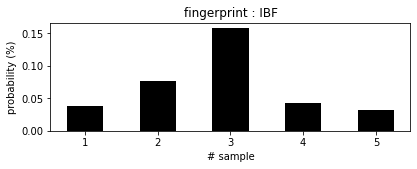

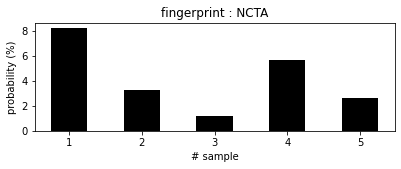

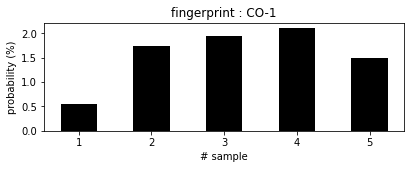

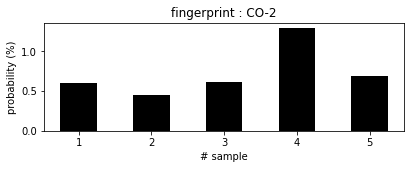

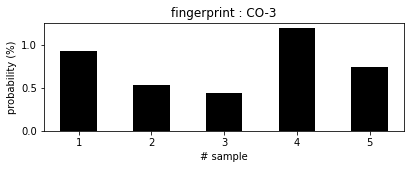

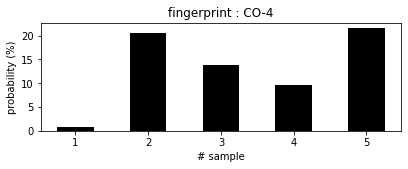

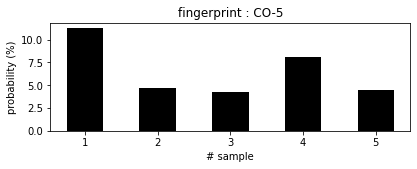

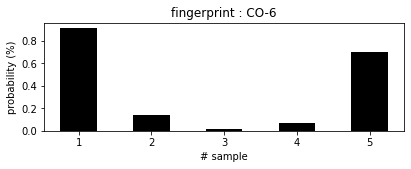

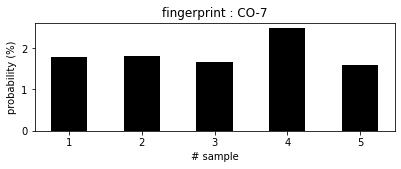

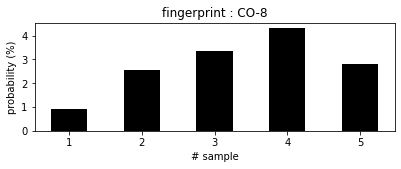

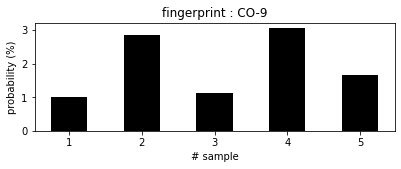

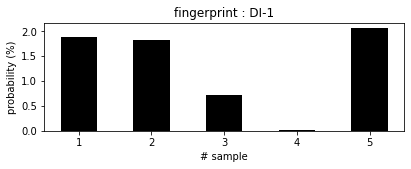

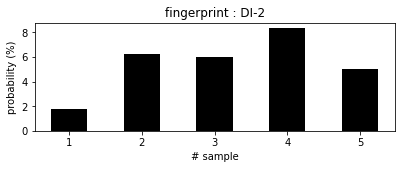

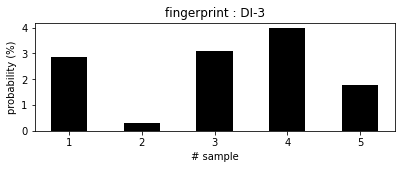

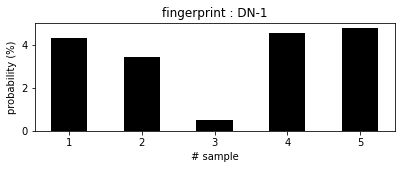

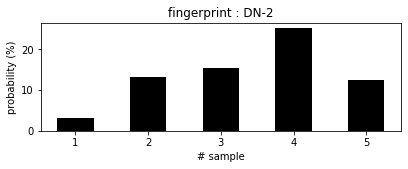

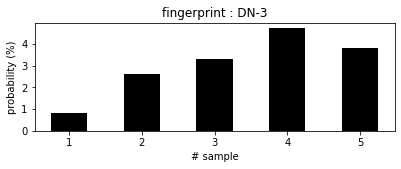

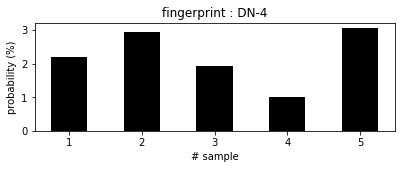

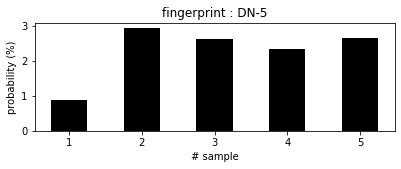

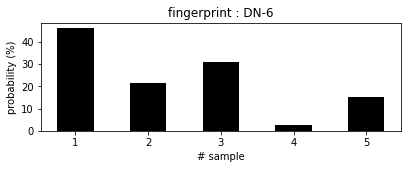

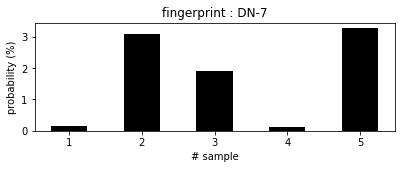

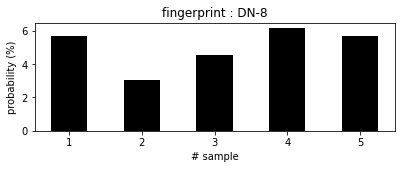

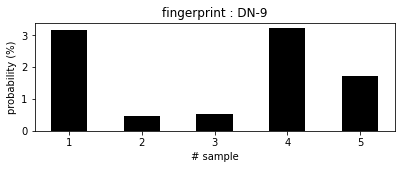

In [11]:
labels = [
           'IBF', 
           'NCTA', 
           'CO-1', 
           'CO-2', 
           'CO-3', 
           'CO-4', 
           'CO-5', 
           'CO-6', 
           'CO-7', 
           'CO-8',
           'CO-9',  
           'DI-1',
           'DI-2',
           'DI-3',
           'DN-1',
           'DN-2',
           'DN-3',
           'DN-4', 
           'DN-5',
           'DN-6', 
           'DN-7', 
           'DN-8',
           'DN-9'
           ]
for fingerprint in range(23):
  dx = 1
  width = 0.5
  run_i = 0
  fig = plt.figure(figsize=(5, 1.5))
  ax = fig.add_axes([0,0,1,1])
  ax.yaxis.ylim = [0, 100]
  for run in range(5): 
    run_i += 1
    SUM = np.sum(np.abs(KarimiJafari_offline_COEFF[0:23,run]))
    probability = 100 * np.abs(KarimiJafari_offline_COEFF[0:23,run]) / SUM
    ax.bar(1 + run * dx, probability[fingerprint], color = 'black', \
           width = width, label = labels[fingerprint]) 
  ax.xaxis.set_label_text('# sample')
  ax.yaxis.set_label_text('probability (%)')
  ax.title.set_text('fingerprint : '+labels[fingerprint])
  ax.xaxis.set_ticks((np.linspace(1,5,5)))
  plt.show()

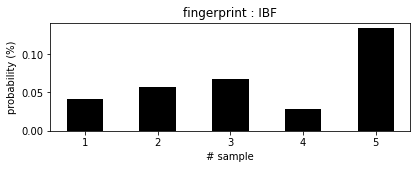

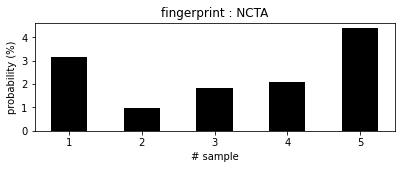

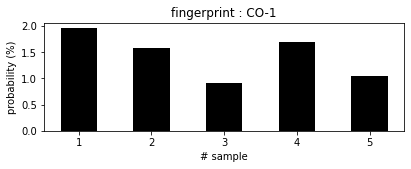

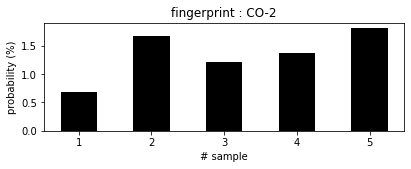

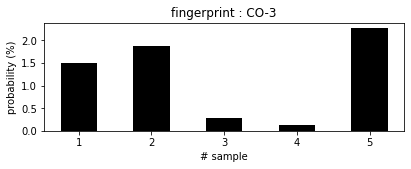

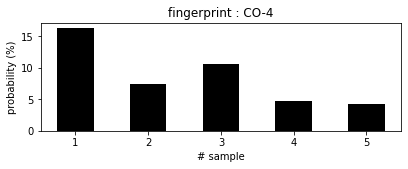

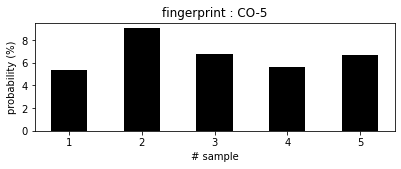

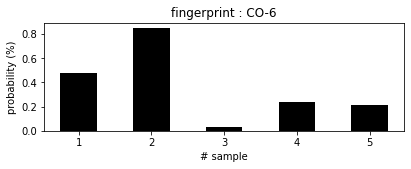

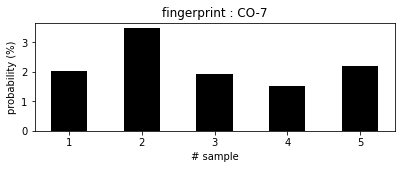

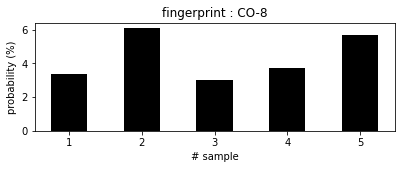

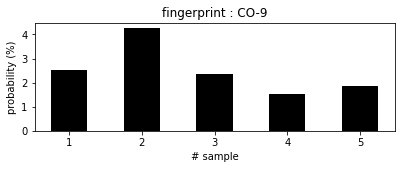

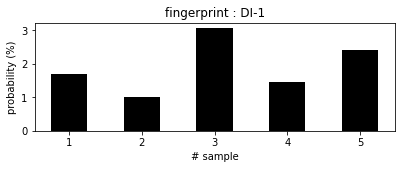

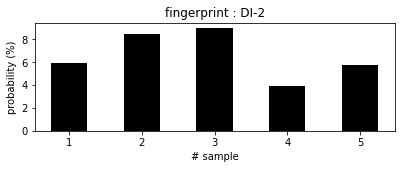

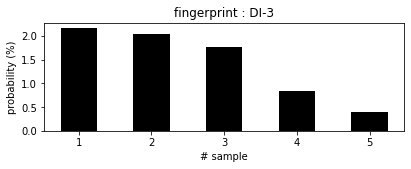

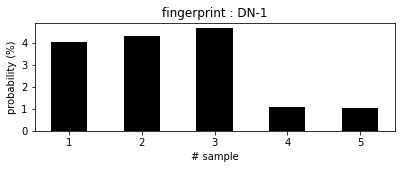

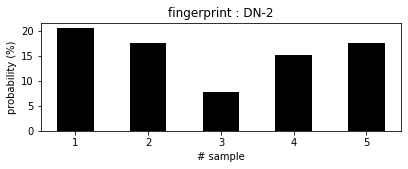

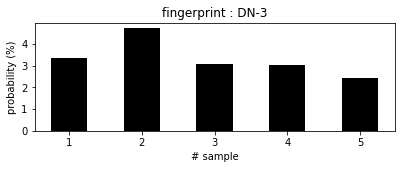

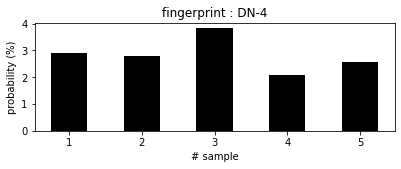

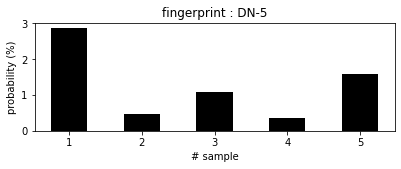

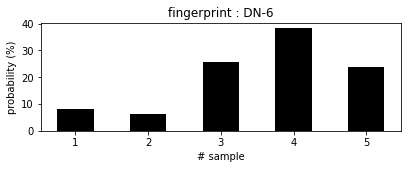

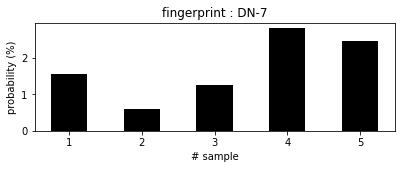

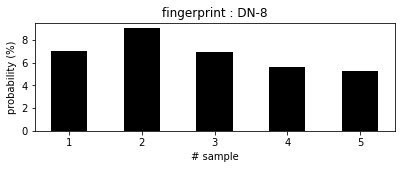

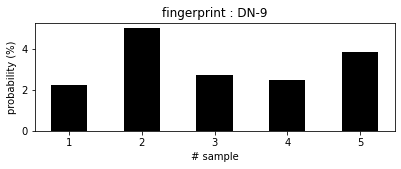

In [12]:
labels = [
           'IBF', 
           'NCTA', 
           'CO-1', 
           'CO-2', 
           'CO-3', 
           'CO-4', 
           'CO-5', 
           'CO-6', 
           'CO-7', 
           'CO-8',
           'CO-9',  
           'DI-1',
           'DI-2',
           'DI-3',
           'DN-1',
           'DN-2',
           'DN-3',
           'DN-4', 
           'DN-5',
           'DN-6', 
           'DN-7', 
           'DN-8',
           'DN-9'
           ]
for fingerprint in range(23):
  dx = 1
  width = 0.5
  run_i = 0
  fig = plt.figure(figsize=(5, 1.5))
  ax = fig.add_axes([0,0,1,1])
  ax.yaxis.ylim = [0, 100]
  for run in range(5): 
    run_i += 1
    SUM = np.sum(np.abs(KarimiJafari_offline_COEFF[0:23,run+5]))
    probability = 100 * np.abs(KarimiJafari_offline_COEFF[0:23,run+5]) / SUM
    ax.bar(1 + run * dx, probability[fingerprint], color = 'black', \
           width = width, label = labels[fingerprint]) 
  ax.xaxis.set_label_text('# sample')
  ax.yaxis.set_label_text('probability (%)')
  ax.title.set_text('fingerprint : '+labels[fingerprint])
  ax.xaxis.set_ticks((np.linspace(1,5,5)))
  plt.show()

# working on data of: 'KarimiJafari_inline'

In [7]:
dataset_name = 'KarimiJafari_inline_avg'
KarimiJafari_inline_avg_available = 1
if KarimiJafari_inline_avg_available == 0:
  xs_cut_MIN = 700
  xs_cut_MAX = 1200
  print('creating data for dataset = ', dataset_name)
  MATRIX, tMATRIX, tMATRIX_MATRIX, inv_tMATRIX_MATRIX = \
  BuildMatrixSET(CUTs, MATRIX_available)
  file = 'dVFS_ExSysR_KarimiJafari_inline_avg.xlsx'
  xl = pd.ExcelFile(file)
  ListKarimiJafari = xl.sheet_names
  xs = np.linspace(xs_cut_MIN, xs_cut_MAX, CUTs)
  KarimiJafari = np.zeros((len(xs),len(ListKarimiJafari)))
  KarimiJafari_norm = np.zeros((len(xs),len(ListKarimiJafari)))
  i = 0
  for item in ListKarimiJafari: 
    data = xl.parse(item)
    np_data = data.to_numpy()
    x = np_data[:, 0]
    y = np_data[:, 1]
    #spl = UnivariateSpline(x, y)
    #spl.set_smoothing_factor(0.00000001)
    #
    spl = CubicSpline(x, y)
    # 
    ys = spl(xs)
    KarimiJafari[:,i] = ys
    MIN = ys.min()
    if MIN == 0:
      MIN = 1e-8
    MAX = ys.max()
    KarimiJafari_norm[:,i] = (ys - MIN) / (MAX - MIN)
    i = i + 1
  KarimiJafari_ERR = np.zeros((KarimiJafari_norm.shape[1],1))
  KarimiJafari_COEFF = np.zeros((MATRIX.shape[1],KarimiJafari_norm.shape[1]))
  for karimijafari in range(KarimiJafari_norm.shape[1]):
      Y = KarimiJafari_norm[:, karimijafari]
      tMATRIX_Y = np.matmul(tMATRIX, Y) 
      KarimiJafari_COEFF[:, karimijafari] = np.matmul(inv_tMATRIX_MATRIX,\
                                                      tMATRIX_Y)
      Y_cal = np.matmul(MATRIX, KarimiJafari_COEFF[:, karimijafari])
      Err = abs(Y - Y_cal)
      KarimiJafari_ERR[karimijafari,0] = Err.sum()
  print('creating data for dataset = ', dataset_name)
  print('writing to disk data for dataset = ', dataset_name)
  np.savetxt("KarimiJafari_inline_avg.txt", KarimiJafari, delimiter=",")
  np.savetxt("KarimiJafari_inline_avg_norm.txt", KarimiJafari_norm, \
             delimiter=",")
  np.savetxt("KarimiJafari_inline_avg_COEFF.txt", \
             KarimiJafari_COEFF, delimiter=",")
else: 
  print('loading from to disk data for dataset = ', dataset_name)
  KarimiJafari_inline_avg = np.loadtxt("KarimiJafari_inline_avg.txt",\
                                       delimiter=",")
  KarimiJafari_inline_avg_norm = np.loadtxt("KarimiJafari_inline_avg_norm.txt",\
                                            delimiter=",")
  KarimiJafari_inline_avg_COEFF = \
  np.loadtxt("KarimiJafari_inline_avg_COEFF.txt", delimiter=",")
  print('DONE: loading from to disk data for dataset = ', dataset_name)

loading from to disk data for dataset =  KarimiJafari_inline_avg
DONE: loading from to disk data for dataset =  KarimiJafari_inline_avg


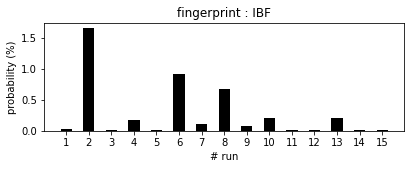

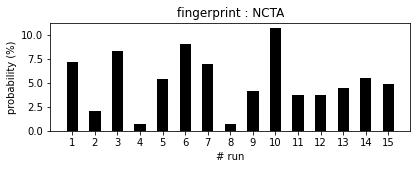

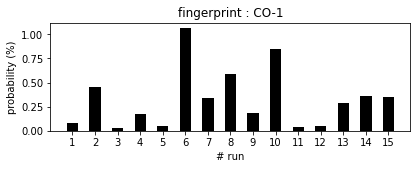

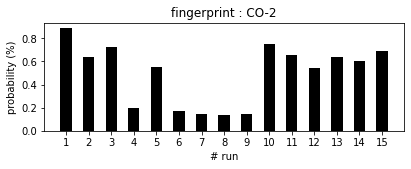

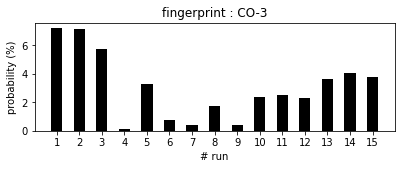

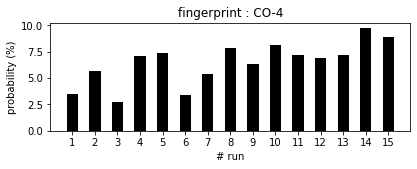

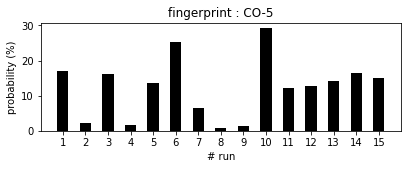

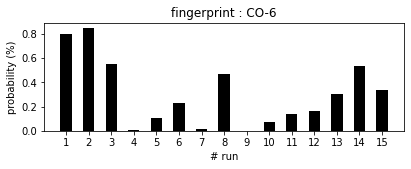

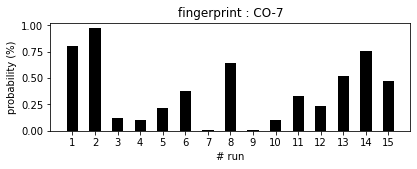

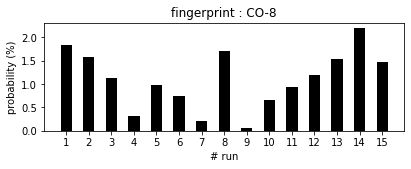

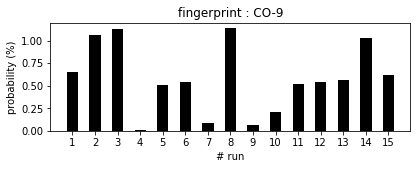

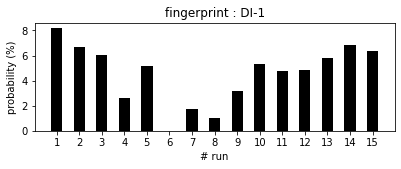

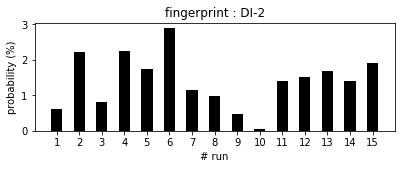

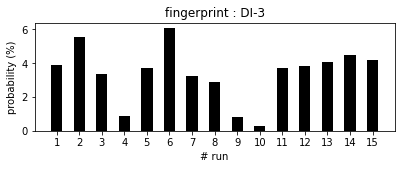

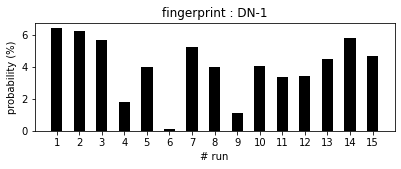

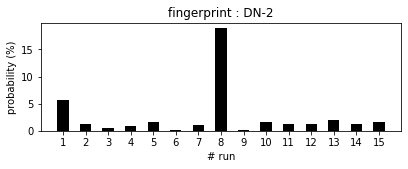

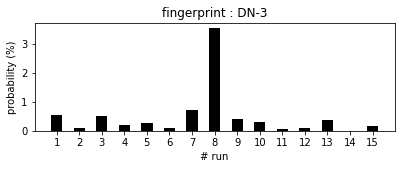

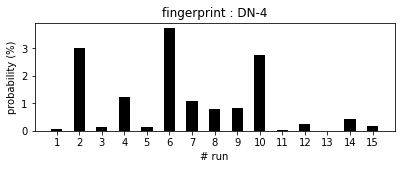

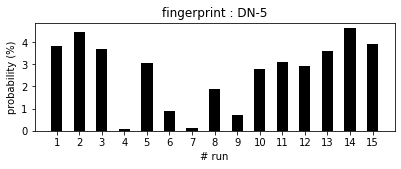

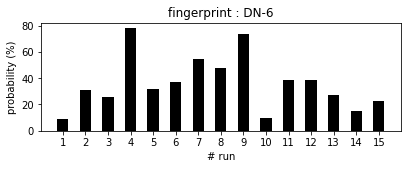

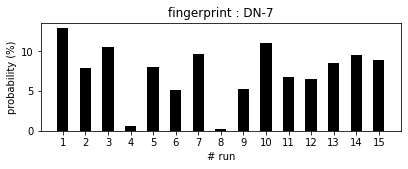

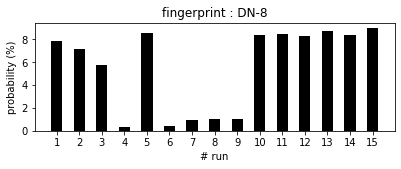

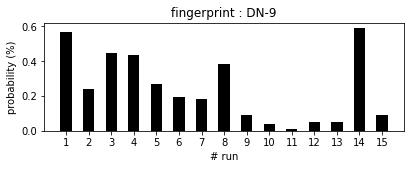

In [ ]:
# plot 1 - table 1 - fig 7 
labels = [
           'IBF', 
           'NCTA', 
           'CO-1', 
           'CO-2', 
           'CO-3', 
           'CO-4', 
           'CO-5', 
           'CO-6', 
           'CO-7', 
           'CO-8',
           'CO-9',  
           'DI-1',
           'DI-2',
           'DI-3',
           'DN-1',
           'DN-2',
           'DN-3',
           'DN-4', 
           'DN-5',
           'DN-6', 
           'DN-7', 
           'DN-8',
           'DN-9'
           ]
for fingerprint in range(23):
  dx = 1
  width = 0.5
  run_i = 0
  fig = plt.figure(figsize=(5, 1.5))
  ax = fig.add_axes([0,0,1,1])
  ax.yaxis.ylim = [0, 100]
  for run in range(15): 
    run_i += 1
    SUM = np.sum(np.abs(KarimiJafari_inline_avg_COEFF[0:23,run+6]))
    probability = 100 * np.abs(KarimiJafari_inline_avg_COEFF[0:23,run+6]) / SUM
    ax.bar(1 + run * dx, probability[fingerprint], color = 'black', \
           width = width, label = labels[fingerprint]) 
  ax.xaxis.set_label_text('# run')
  ax.yaxis.set_label_text('probability (%)')
  ax.title.set_text('fingerprint : '+labels[fingerprint])
  ax.xaxis.set_ticks((np.linspace(1,15,15)))
  plt.show()

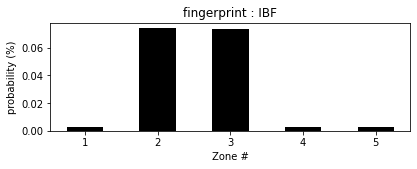

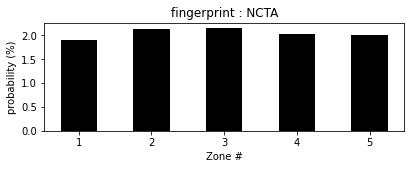

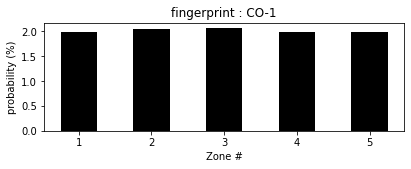

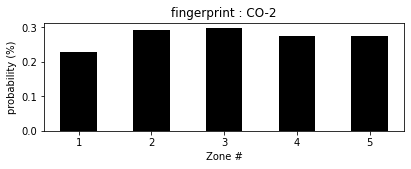

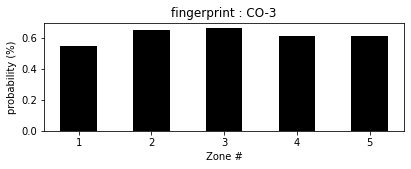

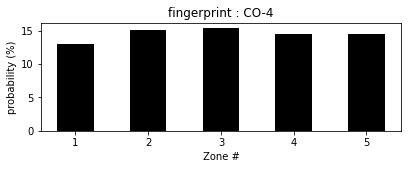

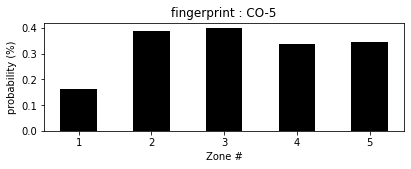

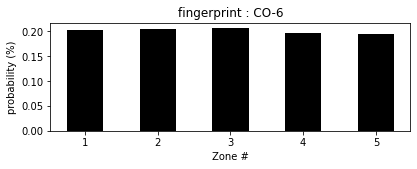

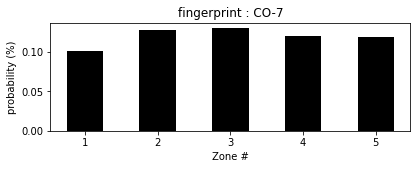

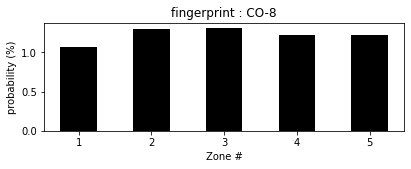

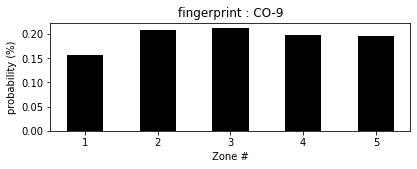

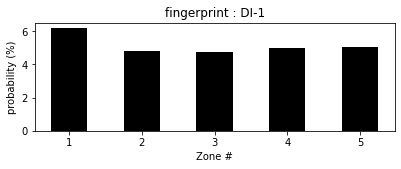

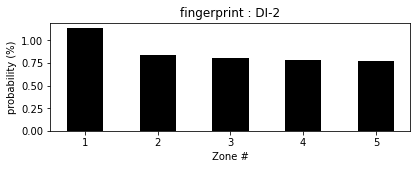

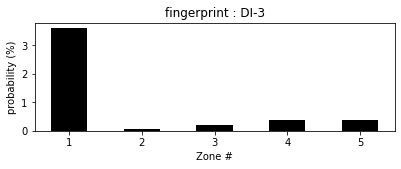

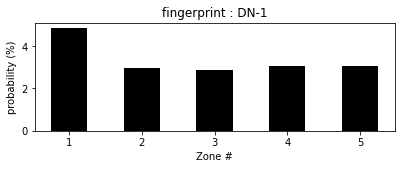

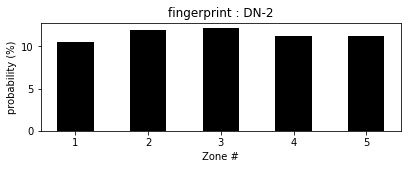

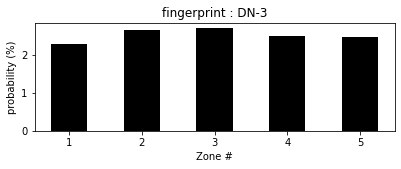

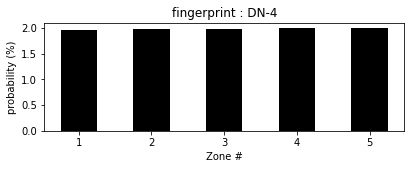

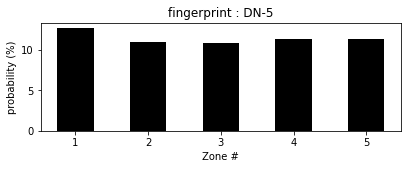

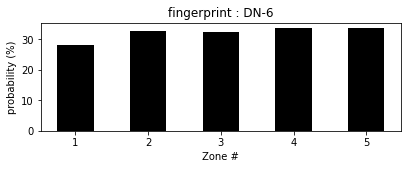

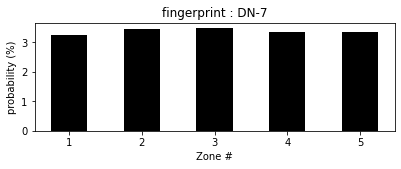

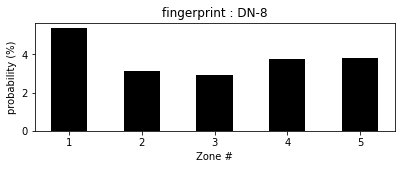

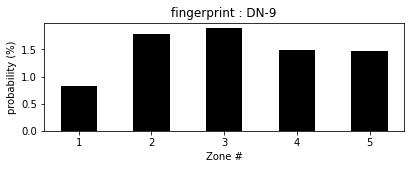

In [ ]:
# plot 2 - fig 13 - no report <<<<
labels = [
           'IBF', 
           'NCTA', 
           'CO-1', 
           'CO-2', 
           'CO-3', 
           'CO-4', 
           'CO-5', 
           'CO-6', 
           'CO-7', 
           'CO-8',
           'CO-9',  
           'DI-1',
           'DI-2',
           'DI-3',
           'DN-1',
           'DN-2',
           'DN-3',
           'DN-4', 
           'DN-5',
           'DN-6', 
           'DN-7', 
           'DN-8',
           'DN-9'
           ]
for fingerprint in range(23):
  dx = 1
  width = 0.5
  run_i = 0
  fig = plt.figure(figsize=(5, 1.5))
  ax = fig.add_axes([0,0,1,1])
  ax.yaxis.ylim = [0, 100]
  for run in range(5): 
    run_i += 1
    SUM = np.sum(np.abs(KarimiJafari_inline_avg_COEFF[0:23,run]))
    probability = 100 * np.abs(KarimiJafari_inline_avg_COEFF[0:23,run]) / SUM
    
    #ax.bar(fingerprints,probability)
    ax.bar(1 + run * dx, probability[fingerprint], color = 'black', width = width, label = labels[fingerprint]) 
  ax.xaxis.set_label_text('Zone #')
  ax.yaxis.set_label_text('probability (%)')
  ax.title.set_text('fingerprint : '+labels[fingerprint])
  ax.xaxis.set_ticks((np.linspace(1,5,5)))
  plt.show()

# working on data of: 'kMC'

In [ ]:
################################################################################
dataset_name = 'kMC'
kMC_available = 1
if kMC_available == 0:
  print('creating data for dataset = ', dataset_name)
  xs_cut_MIN = 200
  xs_cut_MAX = 3700
  xs = np.linspace(xs_cut_MIN, xs_cut_MAX, CUTs)
  # ----------------------------------------------------------------------------
  print('reading DFT data ...')
  xlf = pd.ExcelFile('fingerprints_clean.xlsx')
  List = xlf.sheet_names
  FP_norm = np.transpose(xs)  
  for item in List: 
    data = xlf.parse(item)
    np_data = data.to_numpy()
    tr_data = np_data[ np.where( np_data[:, 0] > xs_cut_MIN ) ] 
    tr_data = tr_data[ np.where( tr_data[:, 0] < xs_cut_MAX ) ] 
    x298 = tr_data[:, 0]
    y298 = tr_data[:, 1]
    #spl = UnivariateSpline(x298, y298)
    #spl.set_smoothing_factor(0.00000001)
    #
    spl = CubicSpline(x298, y298)
    # 
    ys298 = spl(xs)
    x343 = tr_data[:, 2]
    y343 = tr_data[:, 3]
    #spl = UnivariateSpline(x343, y343)
    #spl.set_smoothing_factor(0.00000001)
    #
    spl = CubicSpline(x343, y343)
    # 
    ys343 = spl(xs)
    x353 = tr_data[:, 4]
    y353 = tr_data[:, 5]
    #spl = UnivariateSpline(x353, y353)
    #spl.set_smoothing_factor(0.00000001)
    #
    spl = CubicSpline(x353, y353)
    # 
    ys353= spl(xs)
    x363 = tr_data[:, 6]
    y363 = tr_data[:, 7]
    #spl = UnivariateSpline(x363, y363)
    #spl.set_smoothing_factor(0.00000001)
    #
    spl = CubicSpline(x363, y363)
    # 
    ys363 = spl(xs)
    x_avg = xs
    y_avg = (ys298 + ys343 + ys353 + ys363) / 4 
    MIN = y_avg.min()
    if MIN == 0:
      MIN = 1e-8
    MAX = y_avg.max()
    norm_y = (y_avg - MIN) / (MAX - MIN) 
    FP_norm = np.vstack((FP_norm, np.transpose(norm_y)))
  FP_spectra = np.transpose(np.linspace(xs_cut_MIN, xs_cut_MAX, CUTs))
  FP_intensity = np.transpose(FP_norm[1:,:])
  FP_intensity_sorted = np.array([
                        FP_intensity[:,0],
                        FP_intensity[:,1], 
                        FP_intensity[:,2],
                        FP_intensity[:,3],
                        FP_intensity[:,4],
                        FP_intensity[:,5],
                        FP_intensity[:,6],
                        FP_intensity[:,7],
                        FP_intensity[:,11],
                        FP_intensity[:,12],
                        FP_intensity[:,14],
                        FP_intensity[:,15],
                        FP_intensity[:,16],
                        FP_intensity[:,8],
                        FP_intensity[:,9],
                        FP_intensity[:,17],
                        FP_intensity[:,18],
                        FP_intensity[:,19],
                        FP_intensity[:,13],
                        FP_intensity[:,10],
                        FP_intensity[:,20],
                        FP_intensity[:,21],
                        FP_intensity[:,22]                   
  ])
  FP_intensity_sorted = np.transpose(FP_intensity_sorted)
  print('DONE: reading DFT data ...')
  # ----------------------------------------------------------------------------
  file = 'kMC_300_400.xlsx'
  print('reading data from file ', file)
  xl = pd.ExcelFile(file)
  print('DONE: reading data from file ', file)
  ListkMC = xl.sheet_names
  for item in ListkMC:
    print('processing item: ', item, 'from file: ', file)
    kMC_data = xl.parse(item)
    np_kMC_data = kMC_data.to_numpy()
    kMC_intensities = np.zeros((FP_intensity_sorted.shape[0], \
                                (np_kMC_data.shape[0])))
    for local_time in range(np_kMC_data.shape[0]):
      local_raman = 0
      for local_pairs in range((np_kMC_data.shape[1]-1)):
        local_raman += \
        np_kMC_data[local_time, local_pairs+1] \
        * FP_intensity_sorted[:,local_pairs]
      kMC_intensities[:, local_time] = local_raman
    print('DONE: processing item: ', item, 'from file: ', file)
    print('writing to disk data for dataset: ', dataset_name, 'item: ', item)
    np.savetxt('kMC_spectra_'+item+'.txt', kMC_intensities, delimiter=",")  
    np.savetxt('kMC_COEFF_'+item+'.txt', np_kMC_data[:,1:], delimiter=",") 
    print('DONE: writing to disk data for dataset: ', dataset_name, \
          'item: ', item)
else:
  print('loading from to disk data for dataset = ', dataset_name)
  kMC_intensities_300 = np.loadtxt("kMC_spectra_300.txt",  delimiter=",")
  kMC_COEFF_300 = np.loadtxt("kMC_COEFF_300.txt",  delimiter=",")
  kMC_intensities_325 = np.loadtxt("kMC_spectra_325.txt",  delimiter=",")
  kMC_COEFF_325 = np.loadtxt("kMC_COEFF_325.txt",  delimiter=",")
  kMC_intensities_350 = np.loadtxt("kMC_spectra_350.txt",  delimiter=",")
  kMC_COEFF_350 = np.loadtxt("kMC_COEFF_350.txt",  delimiter=",")
  kMC_intensities_375 = np.loadtxt("kMC_spectra_375.txt",  delimiter=",")
  kMC_COEFF_375 = np.loadtxt("kMC_COEFF_375.txt",  delimiter=",")
  kMC_intensities_400 = np.loadtxt("kMC_spectra_400.txt",  delimiter=",")
  kMC_COEFF_400 = np.loadtxt("kMC_COEFF_400.txt",  delimiter=",")
  print('DONE: loading from to disk data for dataset = ', dataset_name)

loading from to disk data for dataset =  kMC
DONE: loading from to disk data for dataset =  kMC


In [ ]:
labels = [
           'IBF', 
           'NCTA', 
           'CO-1', 
           'CO-2', 
           'CO-3', 
           'CO-4', 
           'CO-5', 
           'CO-6', 
           'CO-7', 
           'CO-8',
           'CO-9',  
           'DI-1',
           'DI-2',
           'DI-3',
           'DN-1',
           'DN-2',
           'DN-3',
           'DN-4', 
           'DN-5',
           'DN-6', 
           'DN-7', 
           'DN-8',
           'DN-9'
           ]

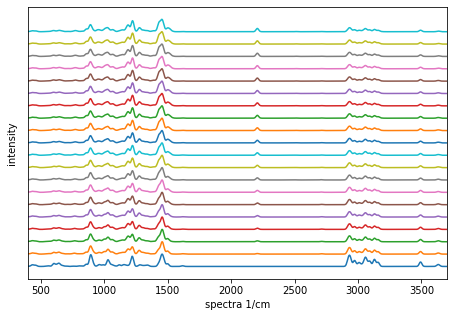

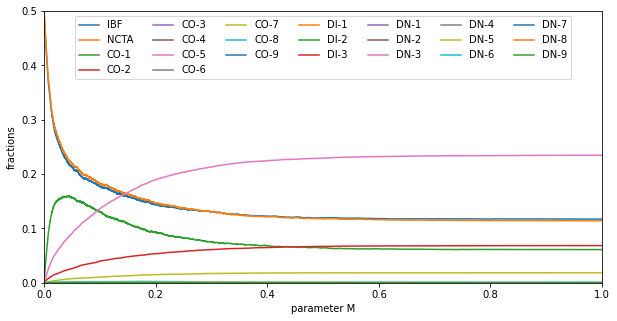

In [ ]:
# kMC plotter - 1
resolution = 5000
MMM = kMC_intensities_400
mmm = kMC_COEFF_400
for item in range(kMC_intensities_300.shape[1]):
  MIN = np.min(kMC_intensities_300[:,item])
  if MIN == 0:
    MIN = 1e-8
  MAX = np.max(kMC_intensities_300[:,item])
  MMM[:,item] = \
  (kMC_intensities_300[:,item] - MIN) / (MAX - MIN) 

xs_cut_MIN = 0
xs_cut_MAX = 3700
CUTs = 1000
xs = np.linspace(xs_cut_MIN, xs_cut_MAX, CUTs)
# 
fig = plt.figure(figsize=(7.5, 5))
plt.xlabel('spectra 1/cm')
plt.ylabel('intensity')
plt.xlim(400, 3700)
#ax = plt.axes(projection='3d')
xline = xs
time = 0
up = 0
while (time < MMM.shape[1]):
  yline = time * np.ones((CUTs, 1))
  zline = MMM[:,time] + up
  up += np.max(MMM[:,time])
  plt.plot(xline, zline)
  ax1 = plt.gca()
  #ax1.xaxis.set_ticklabels([])
  ax1.yaxis.set_ticklabels([])
  #ax1.zaxis.set_ticklabels([])
  #for line in ax1.xaxis.get_ticklines():
  #    line.set_visible(False)
  for line in ax1.yaxis.get_ticklines():
      line.set_visible(False)
  #for line in ax1.zaxis.get_ticklines():
  #    line.set_visible(False)
  time += resolution
plt.show()
fig = plt.figure(figsize=(10, 5))
for pair in range(mmm.shape[1]):
  plt.plot(np.linspace(0, 1, mmm.shape[0]), mmm[:,pair])
plt.legend(labels, loc ="upper center", ncol=7)
plt.xlim(0, 1)
plt.ylabel('fractions')
plt.xlabel('parameter M')
plt.ylim(0, 0.5)
plt.show() 

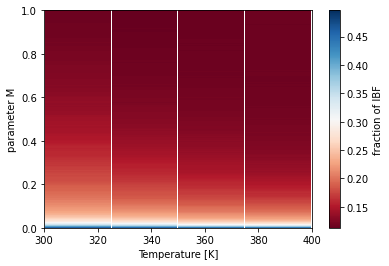

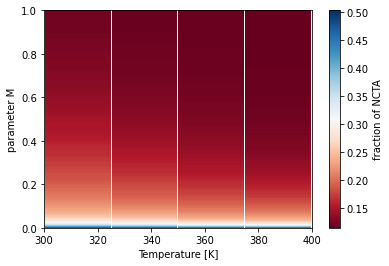

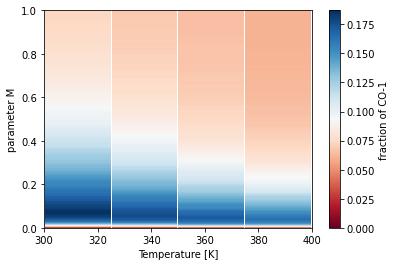

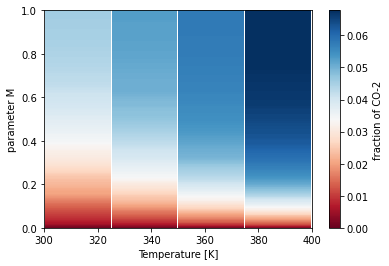

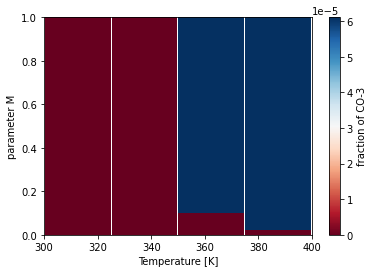

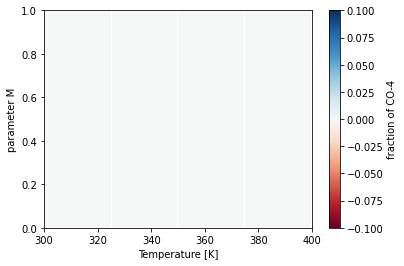

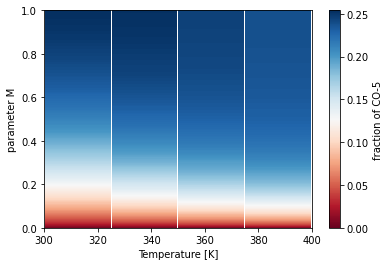

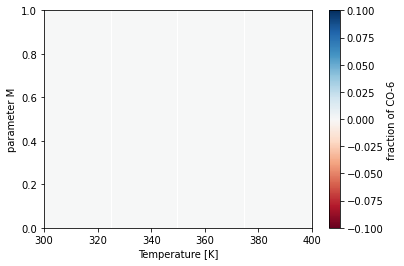

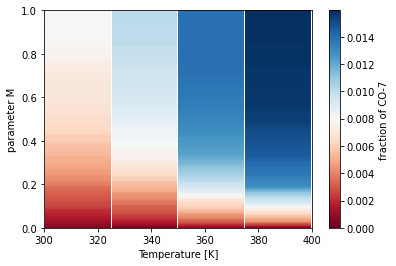

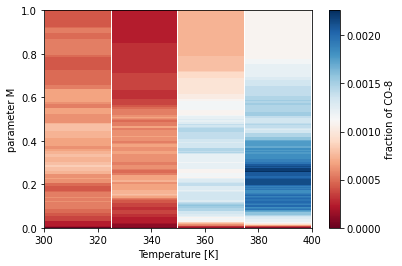

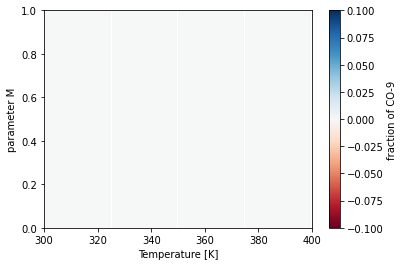

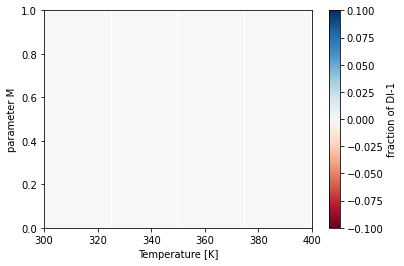

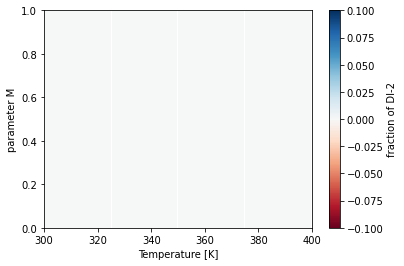

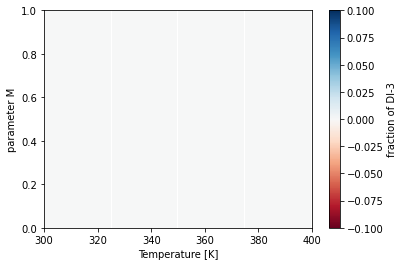

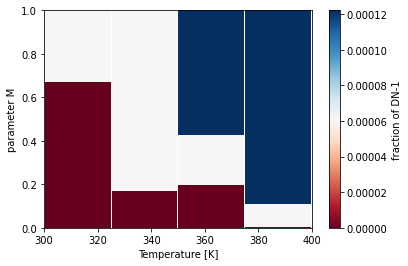

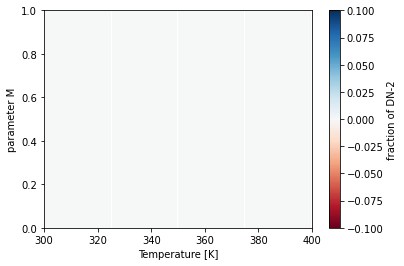

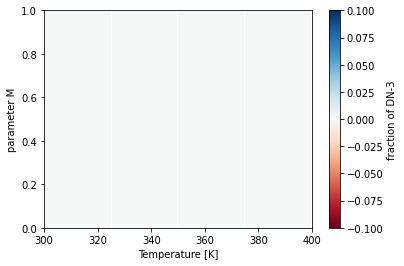

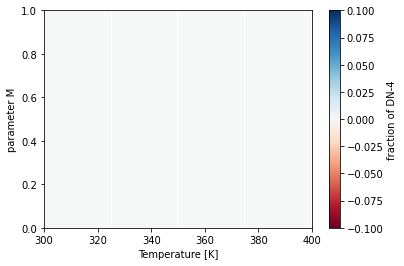

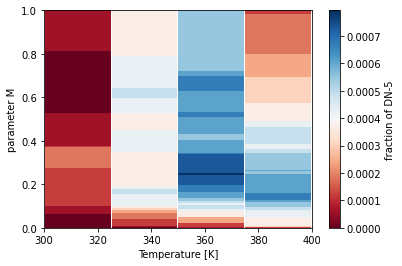

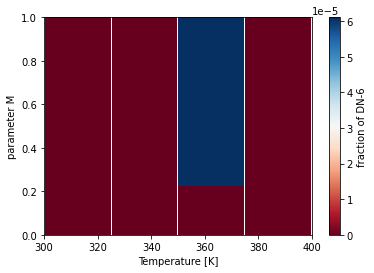

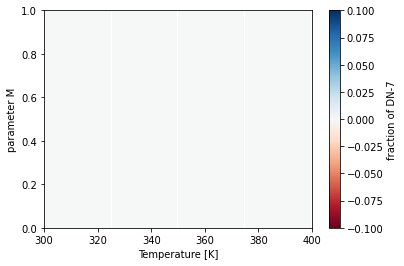

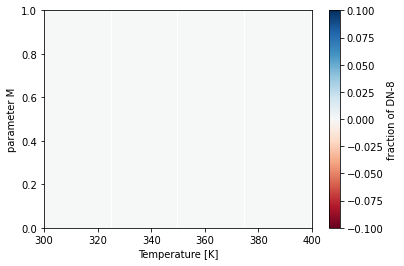

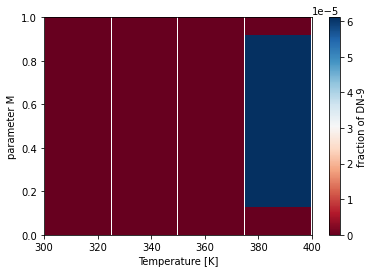

In [ ]:
# kMC plotter - 2 
y, x = np.meshgrid(np.linspace(0, 1, kMC_COEFF_300.shape[0]), \
                   np.array([300, 325, 350, 375, 400]))
for pair in range(kMC_COEFF_300.shape[1]):
  z = np.array([
                    kMC_COEFF_300[:,pair],
                    kMC_COEFF_325[:,pair],
                    kMC_COEFF_350[:,pair],
                    kMC_COEFF_375[:,pair],
                    kMC_COEFF_400[:,pair]])
  # x and y are bounds, so z should be the value *inside* those bounds.
  # Therefore, remove the last value from the z array.
  z = z[:-1, :-1]
  z_min, z_max = z.min(), z.max()
  fig, ax = plt.subplots()
  ax.axis([x.min(), x.max(), y.min(), y.max()])
  c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)  
  plt.xlabel('Temperature [K]')
  plt.ylabel('parameter M')
  cbar = fig.colorbar(c, ax=ax)
  cbar.set_label('fraction of ' + labelss[pair])
  plt.show()

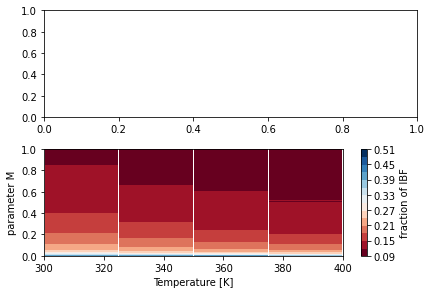

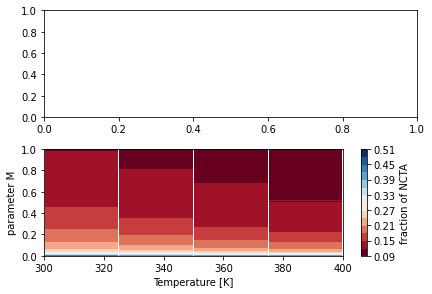

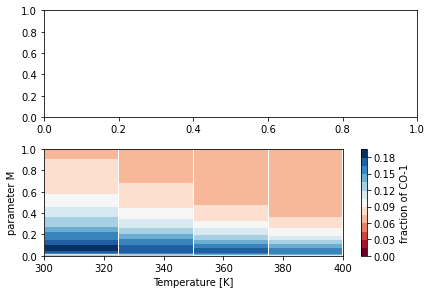

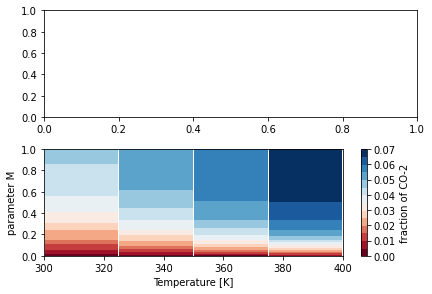

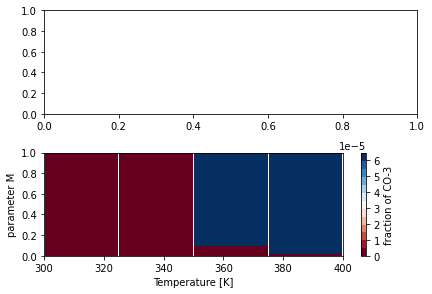

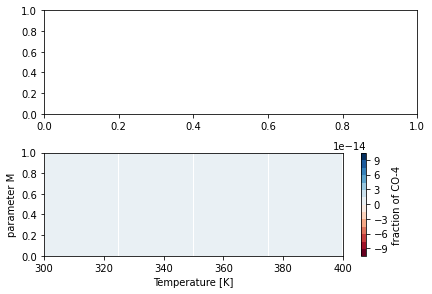

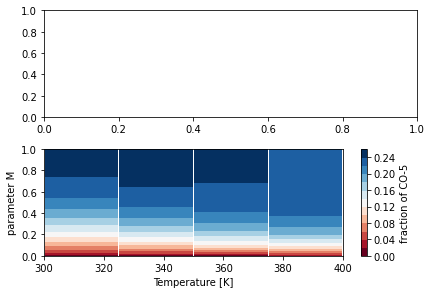

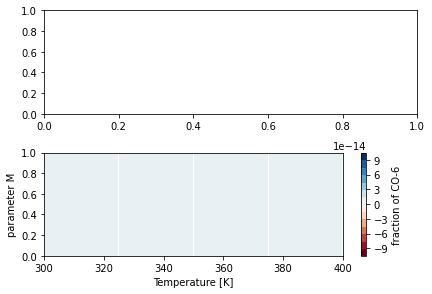

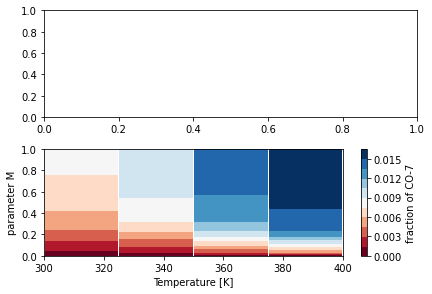

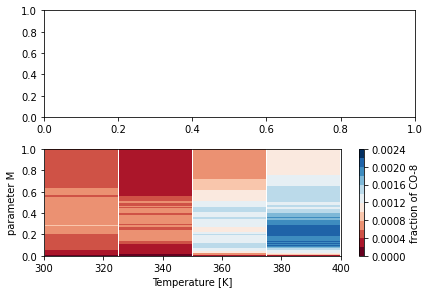

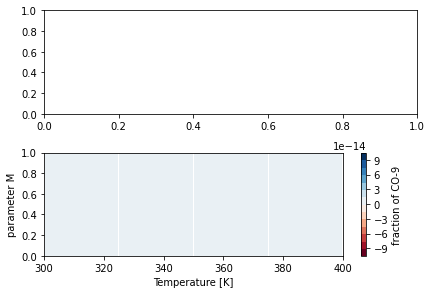

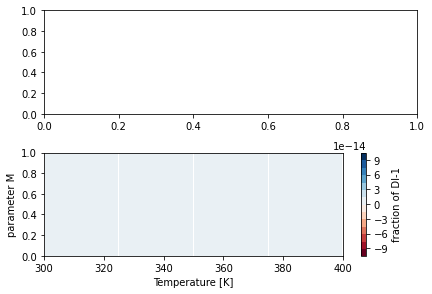

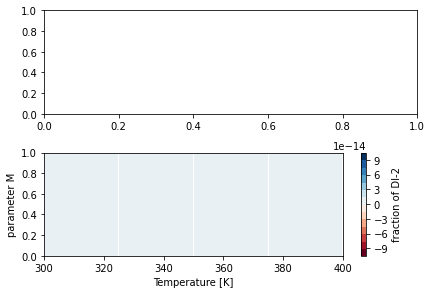

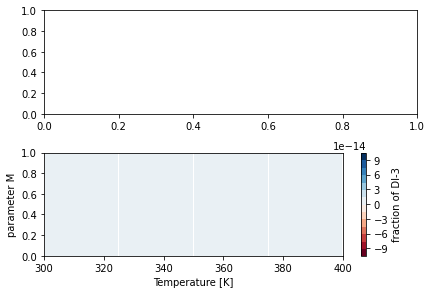

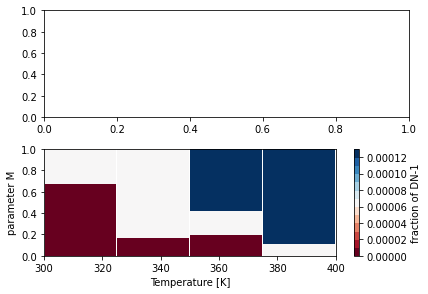

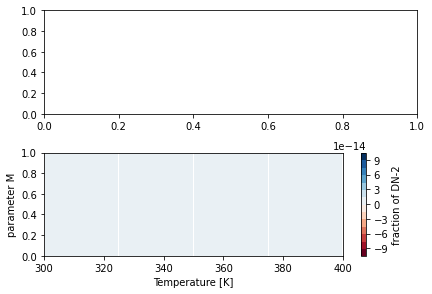

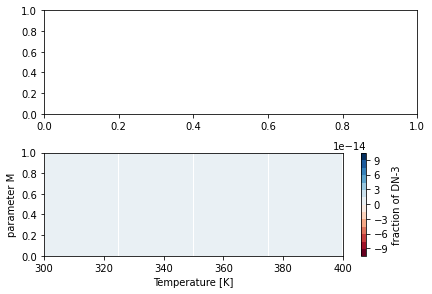

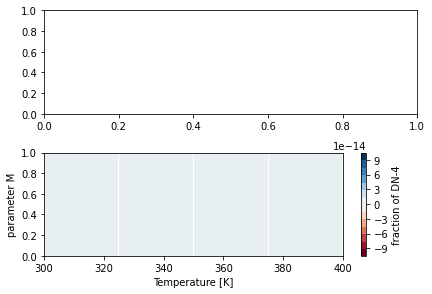

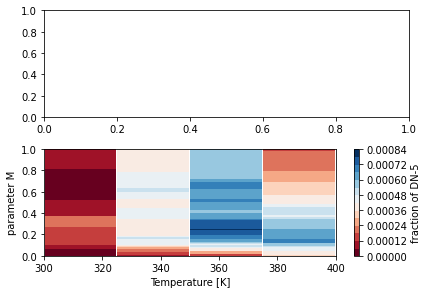

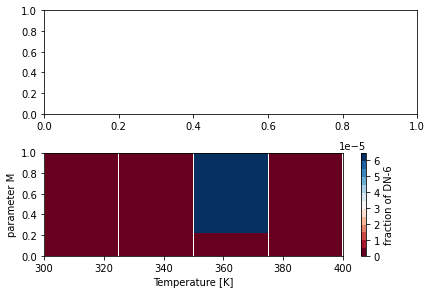

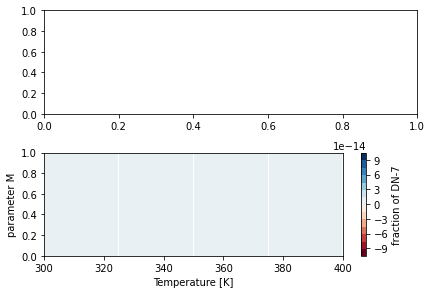

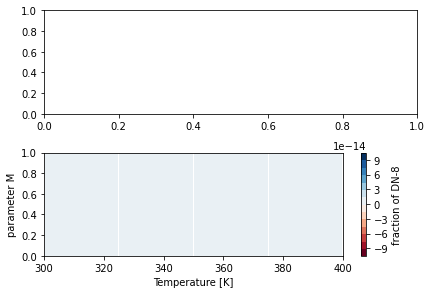

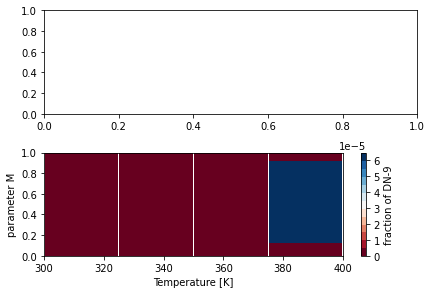

In [ ]:
# kMC plotter - 3
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
dx, dy = 0.05, 0.05
y, x = np.meshgrid(np.linspace(0, 1, kMC_COEFF_300.shape[0]), \
                   np.array([300, 325, 350, 375, 400]))
for pair in range(kMC_COEFF_300.shape[1]):
  z = np.array([
                    kMC_COEFF_300[:,pair],
                    kMC_COEFF_325[:,pair],
                    kMC_COEFF_350[:,pair],
                    kMC_COEFF_375[:,pair],
                    kMC_COEFF_400[:,pair]])
  # x and y are bounds, so z should be the value *inside* those bounds.
  # Therefore, remove the last value from the z array.
  z = z[:-1, :-1]
  levels = MaxNLocator(nbins=15).tick_values(z.min(), z.max())
  cmap = plt.get_cmap('RdBu')
  norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
  fig, (ax1, ax0) = plt.subplots(nrows=2)
  im = ax0.pcolormesh(x, y, z, cmap=cmap, norm=norm)
  cbar = fig.colorbar(im, ax=ax0)
  cbar.set_label('fraction of ' + labelss[pair])
  #cf = ax1.contourf(x[:-1, :-1] + dx/2.,
  #                y[:-1, :-1] + dy/2., z, levels=levels,
  #                cmap=cmap)
  #cbar = fig.colorbar(cf, ax=ax1)
  #cbar.set_label('fraction of ' + labelss[pair])
  fig.tight_layout()
  ax.axis([x.min(), x.max(), y.min(), y.max()])
  plt.xlabel('Temperature [K]')
  plt.ylabel('parameter M')
  plt.show()

# working on data of: 'Soares_RT'

In [8]:
dataset_name = 'Soares_RT'
Soares_available_RT = 1
if Soares_available_RT == 0:
  xs_cut_MIN = 300
  xs_cut_MAX = 1700
  print('creating data for dataset = ', dataset_name)
  MATRIX, tMATRIX, tMATRIX_MATRIX, inv_tMATRIX_MATRIX = \
  BuildMatrixSET(CUTs, MATRIX_available)
  file = 'dVFS_ExSysR_Soares_RT.xlsx'
  xl = pd.ExcelFile(file)
  ListSoares_RT = xl.sheet_names
  xs = np.linspace(xs_cut_MIN, xs_cut_MAX, CUTs)
  Soares_RT = np.zeros((len(xs),len(ListSoares_RT)))
  Soares_RT_norm = np.zeros((len(xs),len(ListSoares_RT)))
  i = 0
  for item in ListSoares_RT: 
    data = xl.parse(item)
    np_data = data.to_numpy()
    x = np_data[:, 0]
    y = np_data[:, 1]
    #spl = UnivariateSpline(x, y)
    #spl.set_smoothing_factor(0.0001)
    #
    spl = CubicSpline(x, y)
    # 
    ys = spl(xs)
    Soares_RT[:,i] = ys
    MIN = ys.min()
    if MIN == 0:
      MIN = 1e-8
    MAX = ys.max()
    Soares_RT_norm[:,i] = (ys - MIN) / (MAX - MIN)
    i = i + 1
  Soares_RT_ERR = np.zeros((Soares_RT_norm.shape[1],1))
  Soares_RT_COEFF = np.zeros((MATRIX.shape[1],Soares_RT_norm.shape[1]))
  for soares_rt in range(Soares_RT_norm.shape[1]):
      Y = Soares_RT_norm[:, soares_rt]
      tMATRIX_Y = np.matmul(tMATRIX, Y) 
      Soares_RT_COEFF[:, soares_rt] = np.matmul(inv_tMATRIX_MATRIX, tMATRIX_Y)
      Y_cal = np.matmul(MATRIX, Soares_RT_COEFF[:, soares_rt])
      Err = abs(Y - Y_cal)
      Soares_RT_ERR[soares_rt,0] = Err.sum()
  print('DONE: creating data for dataset = ', dataset_name)
  print('writing to disk data for dataset = ', dataset_name)
  np.savetxt("Soares_RT.txt", Soares_RT, delimiter=",")
  np.savetxt("Soares_RT_norm.txt", Soares_RT_norm, delimiter=",")
  np.savetxt("Soares_RT_COEFF.txt", Soares_RT_COEFF, delimiter=",")
  print('DONE: writing to disk data for dataset = ', dataset_name)
else: 
  print('loading from disk data for dataset = ', dataset_name)
  Soares_RT = np.loadtxt("Soares_RT.txt", delimiter=",")
  Soares_RT_norm = np.loadtxt("Soares_RT_norm.txt", delimiter=",")
  Soares_RT_COEFF = np.loadtxt("Soares_RT_COEFF.txt", delimiter=",")
  print('DONE: loading from disk data for dataset = ', dataset_name)

loading from disk data for dataset =  Soares_RT
DONE: loading from disk data for dataset =  Soares_RT


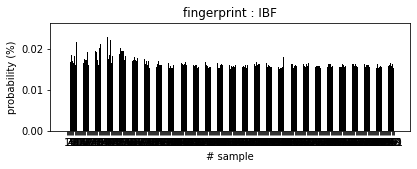

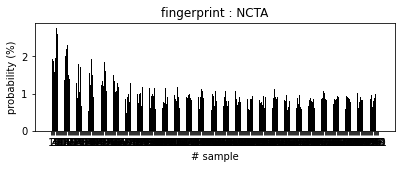

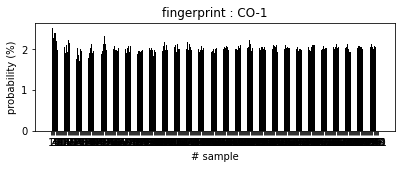

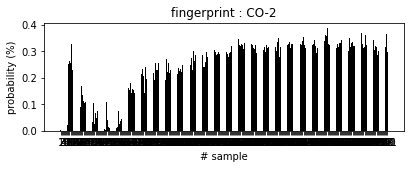

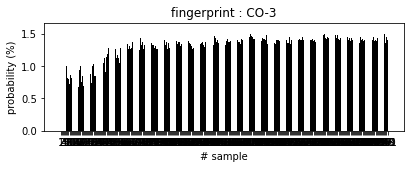

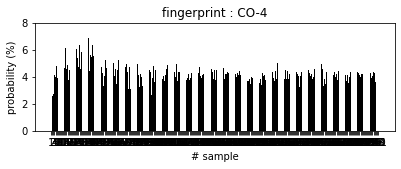

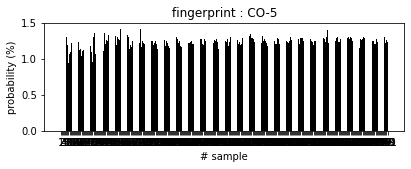

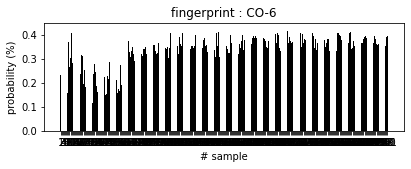

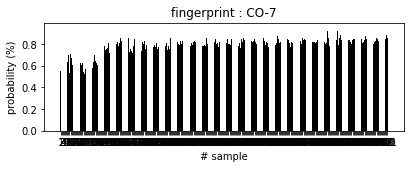

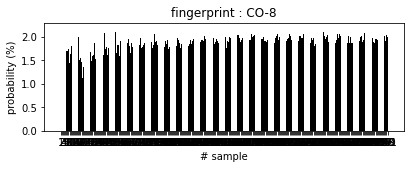

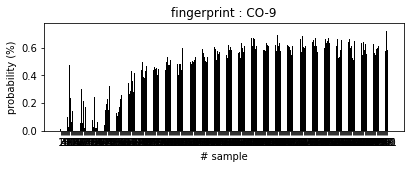

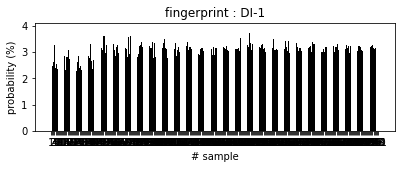

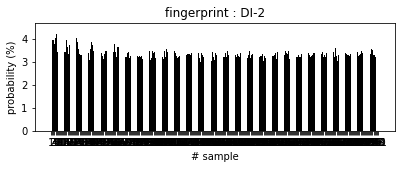

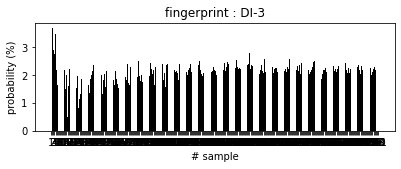

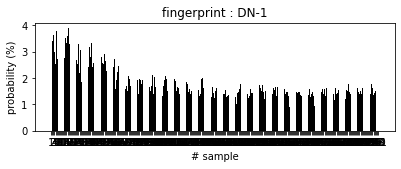

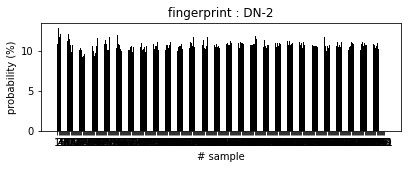

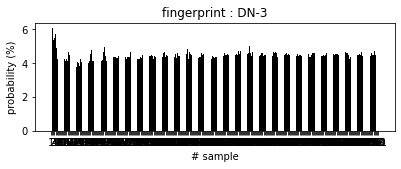

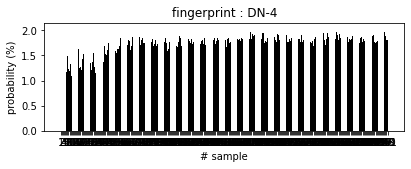

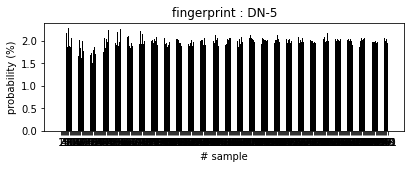

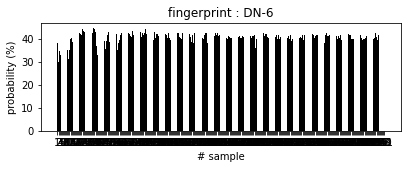

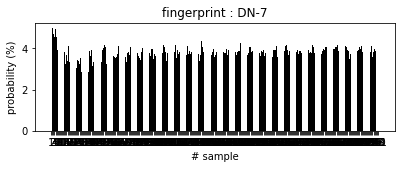

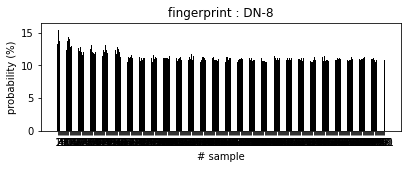

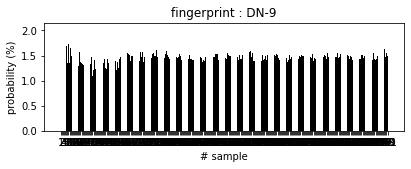

In [13]:
labels = [
           'IBF', 
           'NCTA', 
           'CO-1', 
           'CO-2', 
           'CO-3', 
           'CO-4', 
           'CO-5', 
           'CO-6', 
           'CO-7', 
           'CO-8',
           'CO-9',  
           'DI-1',
           'DI-2',
           'DI-3',
           'DN-1',
           'DN-2',
           'DN-3',
           'DN-4', 
           'DN-5',
           'DN-6', 
           'DN-7', 
           'DN-8',
           'DN-9'
           ]
for fingerprint in range(23):
  dx = 1
  width = 0.5
  run_i = 0
  fig = plt.figure(figsize=(5, 1.5))
  ax = fig.add_axes([0,0,1,1])
  ax.yaxis.ylim = [0, 100]
  for run in range(301): 
    run_i += 1
    SUM = np.sum(np.abs(Soares_RT_COEFF[0:23,run]))
    probability = 100 * np.abs(Soares_RT_COEFF[0:23,run]) / SUM
    ax.bar(1 + run * dx, probability[fingerprint], color = 'black', \
           width = width, label = labels[fingerprint]) 
  ax.xaxis.set_label_text('# sample')
  ax.yaxis.set_label_text('probability (%)')
  ax.title.set_text('fingerprint : '+labels[fingerprint])
  ax.xaxis.set_ticks((np.linspace(1,301,301)))
  plt.show()

# working on data of: 'Soares_T60'

In [9]:
dataset_name = 'Soares_T60'
Soares_available_T60 = 1
if Soares_available_T60 == 0:
  xs_cut_MIN = 300
  xs_cut_MAX = 1700
  print('creating data for dataset = ', dataset_name)
  MATRIX, tMATRIX, tMATRIX_MATRIX, inv_tMATRIX_MATRIX = \
  BuildMatrixSET(CUTs, MATRIX_available)
  file = 'dVFS_ExSysR_Soares_T60.xlsx'
  xl = pd.ExcelFile(file)
  ListSoares_T60 = xl.sheet_names
  xs = np.linspace(xs_cut_MIN, xs_cut_MAX, CUTs)
  Soares_T60 = np.zeros((len(xs),len(ListSoares_T60)))
  Soares_T60_norm = np.zeros((len(xs),len(ListSoares_T60)))
  i = 0
  for item in ListSoares_T60: 
    data = xl.parse(item)
    np_data = data.to_numpy()
    x = np_data[:, 0]
    y = np_data[:, 1]
    #spl = UnivariateSpline(x, y)
    #spl.set_smoothing_factor(0.000001)
    #
    spl = CubicSpline(x, y)
    # 
    ys = spl(xs)
    Soares_T60[:,i] = ys
    MIN = ys.min()
    if MIN == 0:
      MIN = 1e-8
    MAX = ys.max()
    Soares_T60_norm[:,i] = (ys - MIN) / (MAX - MIN)
    i = i + 1
  Soares_T60_ERR = np.zeros((Soares_T60_norm.shape[1],1))
  Soares_T60_COEFF = np.zeros((MATRIX.shape[1],Soares_T60_norm.shape[1]))
  for soares_t60 in range(Soares_T60_norm.shape[1]):
      Y = Soares_T60_norm[:, soares_t60]
      tMATRIX_Y = np.matmul(tMATRIX, Y) 
      Soares_T60_COEFF[:, soares_t60] = np.matmul(inv_tMATRIX_MATRIX, tMATRIX_Y)
      Y_cal = np.matmul(MATRIX, Soares_T60_COEFF[:, soares_t60])
      Err = abs(Y - Y_cal)
      Soares_T60_ERR[soares_t60,0] = Err.sum()
  print('DONE: creating data for dataset = ', dataset_name)
  print('writing to disk data for dataset = ', dataset_name)
  np.savetxt("Soares_T60.txt", Soares_T60, delimiter=",")
  np.savetxt("Soares_T60_norm.txt", Soares_T60_norm, delimiter=",")
  np.savetxt("Soares_T60_COEFF.txt", Soares_T60_COEFF, delimiter=",")
  print('DONE: writing to disk data for dataset = ', dataset_name)
else: 
  print('loading from disk data for dataset = ', dataset_name)
  Soares_T60 = np.loadtxt("Soares_T60.txt", delimiter=",")
  Soares_T60_norm = np.loadtxt("Soares_T60_norm.txt", delimiter=",")
  Soares_T60_COEFF = np.loadtxt("Soares_T60_COEFF.txt", delimiter=",")
  print('DONE: loading from disk data for dataset = ', dataset_name)

loading from disk data for dataset =  Soares_T60
DONE: loading from disk data for dataset =  Soares_T60


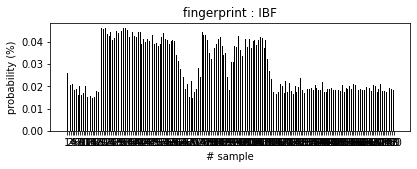

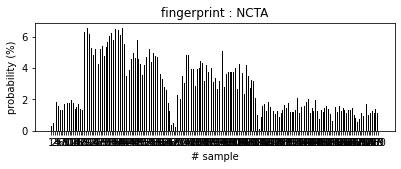

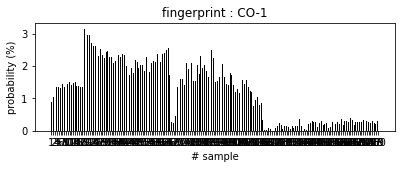

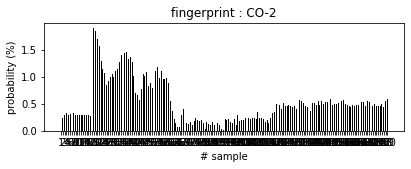

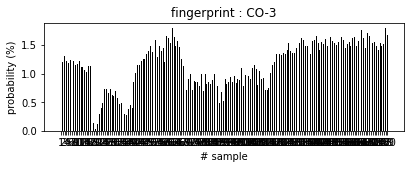

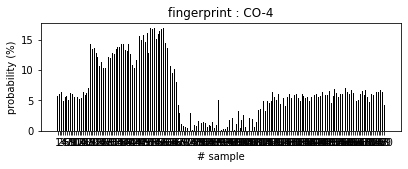

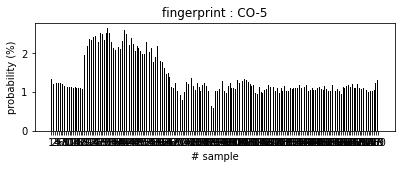

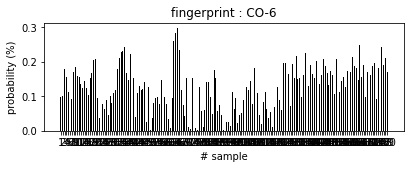

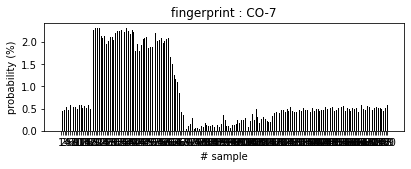

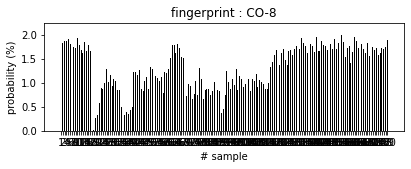

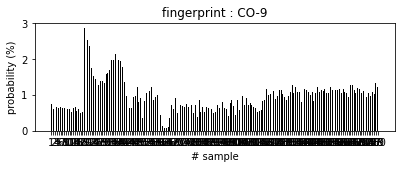

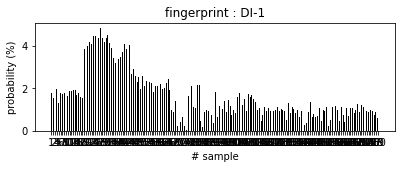

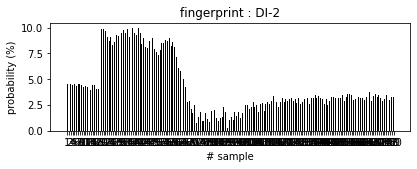

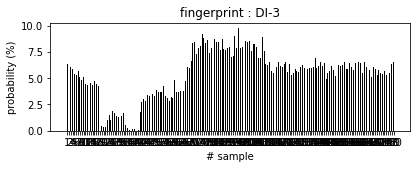

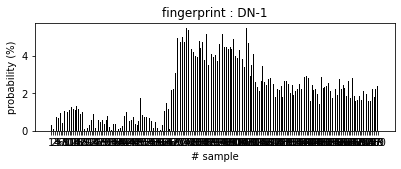

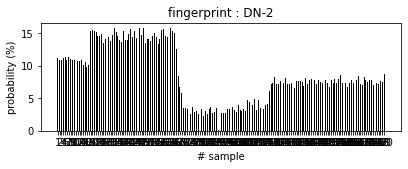

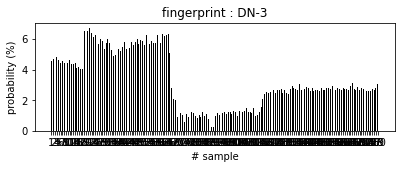

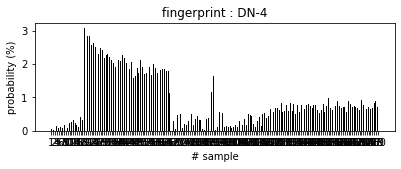

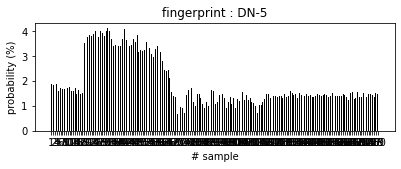

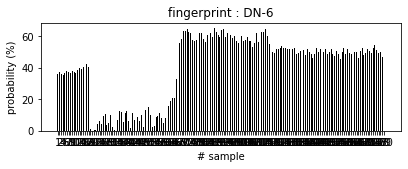

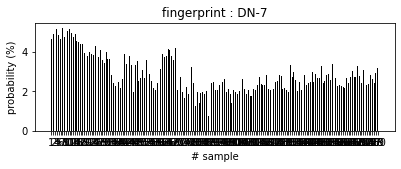

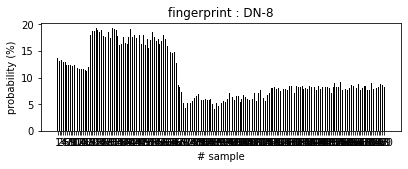

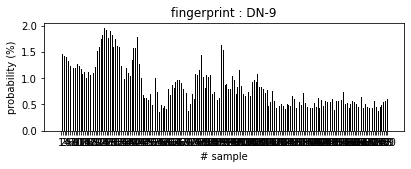

In [15]:
labels = [
           'IBF', 
           'NCTA', 
           'CO-1', 
           'CO-2', 
           'CO-3', 
           'CO-4', 
           'CO-5', 
           'CO-6', 
           'CO-7', 
           'CO-8',
           'CO-9',  
           'DI-1',
           'DI-2',
           'DI-3',
           'DN-1',
           'DN-2',
           'DN-3',
           'DN-4', 
           'DN-5',
           'DN-6', 
           'DN-7', 
           'DN-8',
           'DN-9'
           ]
for fingerprint in range(23):
  dx = 1
  width = 0.5
  run_i = 0
  fig = plt.figure(figsize=(5, 1.5))
  ax = fig.add_axes([0,0,1,1])
  ax.yaxis.ylim = [0, 100]
  for run in range(180): 
    run_i += 1
    SUM = np.sum(np.abs(Soares_T60_COEFF[0:23,run]))
    probability = 100 * np.abs(Soares_T60_COEFF[0:23,run]) / SUM
    ax.bar(1 + run * dx, probability[fingerprint], color = 'black', \
           width = width, label = labels[fingerprint]) 
  ax.xaxis.set_label_text('# sample')
  ax.yaxis.set_label_text('probability (%)')
  ax.title.set_text('fingerprint : '+labels[fingerprint])
  ax.xaxis.set_ticks((np.linspace(1,180,180)))
  plt.show()